# Shapley Value Calculation
A popular approach to tackle the problem of XAI is to use concepts from game theory in particular cooperative game theory.
The most popular method is to use the **Shapley Values** named after Lloyd Shapley, who introduced it in 1951 with his work *"II: The Value of an n-Person Game"*.
We divide  the notebook into two parts, the first part introducing the mathematical background of cooperative game theory.
The second part shows how to calculate Shapley values with the `shapiq` library for given machine learning model.
For practitioners the second part might be most important, but we would highly incourage to read the first part to understand the mathematical implications of Shapley values.
1. **Introduction to Cooperative Game Theory and Shapley Values**
Here we introduce the mathematical background for computing Shapley values and illustrate the concept with a simple example.
2. **Explainable AI with Shapley Value**
Here we show how Shapley values can be used to explain the predictions of machine learning models.


## Cooperative Game Theory
Cooperative game theory deals with the study of games in which players/participants can form groups to achieve a collective payoff. More formally a cooperative game is defined as a tuple $(N,\nu)$ where:
- $N$ is a finite set of players
- $\nu$ is a characteristic function that maps every coalition of players to a real number, i.e. $\nu:2^N \rightarrow \mathbb{R}$

Of particular interest is to find a concept that distributes the payoff of $\nu(N)$ among the players, as it is assumed that the *grand coalition* $N$ is formed.
The distribution of the payoff among the players is called a *solution concept*.

### Shapley Values: A Unique Solution Concept
Given a cooperative game $(N,\nu)$, the Shapley value is a payoff vector dividing the total payoff $\nu(N)$ among the players. The Shapley value of player $i$ is denoted by $\phi_i(\nu)$ and is defined as:
$$
\phi_i(\nu) := \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N|-|S|-1)!}{|N|!} [\nu(S \cup \{i\}) - \nu(S)]
$$
and can be interpreted as the average marginal contribution of player $i$ across all possible permutations of the players.
Its popularity arises from uniquely satisfies the following properties:
- **Efficiency**: The sum of the Shapley values equals the total payoff, i.e. $\sum_{i \in N} \phi_i(\nu) = \nu(N)$.
This property ensures that the total payoff is distributed among all players.

- **Symmetry**: If two players $i$ and $j$ are such that for all coalitions $S \subseteq N \setminus \{i,j\}$, $\nu(S \cup \{i\}) = \nu(S \cup \{j\})$, then $\phi_i(\nu) = \phi_j(\nu)$.
Symmetry implies that players with equal contributions receive equal payoffs.

- **Additivity**: For a game $(N,\nu + \mu)$ based on two games $(N,\nu)$ and $(N,\mu)$, the Shapley value of the sum of the games is the sum of the Shapley values, i.e. $\phi_i(\nu + \mu) = \phi_i(\nu) + \phi_i(\mu)$.
Through Additivity we gain the possibility of calculating the Shapley value for smaller games and summing them up to receive the Shapley value for the larger game.

- **Dummy Player**: If for a player $i$ is holds for all coalitions $S \subseteq N \setminus \{i\}$, $\nu(S \cup \{i\}) - \nu(S) = \nu(\{i\})$ then $\phi_i(\nu) = \nu(\{i\})$.
Through the Dummy Player property, player that not contribute at all receive a value of zero.

### Shapley Values: Cooking Game
To illustrate the concept of Shapley values, we consider a simple example of a cooking game.
The game consists of three cooks, Alice, Bob, and Charlie, who are preparing a meal together.
The characteristic function $\nu$ maps each coalition of players to the quality of the meal.
| Coalition | Quality |
|-----------|---------|
|           | 0       |
| {Alice}   | 2       |
| {Bob}     | 3       |
| {Charlie} | 4       |
| {Alice, Bob} | 7    |
| {Alice, Charlie} | 8 |
| {Bob, Charlie} | 9 |
| {Alice, Bob, Charlie} | 15 |

The chef of the restaurant is now interested in, which cook is the most talented one and would like to distribute a bonus accordingly.
To calculate the Shapley values in `shapiq` we need to define a game instance with the characteristic function and the value function. To do this we create a class `CookingGame` that inherits from the `Game`.

In [22]:
import numpy as np
from shapiq.games import Game


class CookingGame(Game):
    def __init__(self):
        super().__init__(n_players=3, normalize=True, normalization_value=0)
        self.playerid_to_names = {0: "Alice", 1: "Bob", 2: "Charlie"}
        self.characteristic_function = {
            (): 0,
            (0,): 2,
            (1,): 3,
            (2,): 4,
            (0, 1): 7,
            (0, 2): 8,
            (1, 2): 9,
            (0, 1, 2): 15,
        }

    def value_function(self, coalitions: np.ndarray) -> np.ndarray:
        return np.array(
            [
                self.characteristic_function[tuple(np.where(coalition)[0])]
                for coalition in coalitions
            ]
        )


cooking_game = CookingGame()

In the next step we will use the `ExactComputer` to calculate the Shapley values for the cooking game.

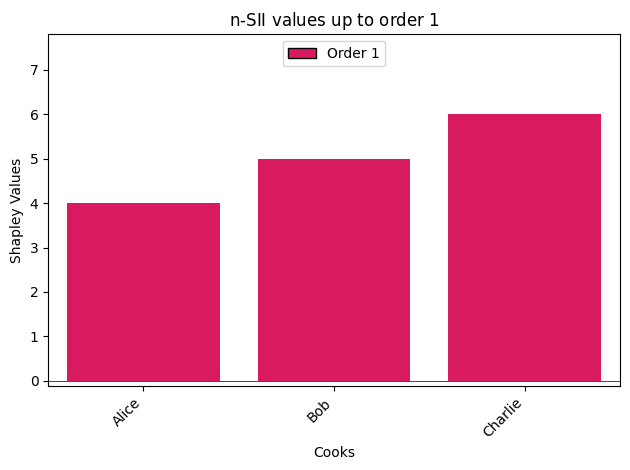

In [23]:
from shapiq.exact import ExactComputer

exact_computer = ExactComputer(n_players=cooking_game.n_players, game_fun=cooking_game)

# Compute the Shapley Values for the game
sv_exact = exact_computer(index="SV")

# Extract the Shapley Values form the Interaction object
shapley_values = sv_exact.values

# Visualize the Shapley Values
sv_exact.plot_stacked_bar(
    xlabel="Cooks", ylabel="Shapley Values", feature_names=["Alice", "Bob", "Charlie"]
)

Based on the Shapley Values we can interpret, that Charlie is the most important cook in the cooking game, as he has the highest value. Thus the chef would give Charlie the highest, Bob the second highest and Alice the lowest bonus.

## Explainable AI with Shapley Values